In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


# Data Creation and model prediction

In [35]:
def generate_synthetic_fico_data(n=10000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data)/10 # Divide by 10 to scale down the values
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)*10
    
    return df

def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)


def behavioral(weights, gamma):
    """
    Modifies the weights according to the specified formula.
    
    Args:
    weights (np.array): Original model weights.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    np.array: Modified weights reflecting behavioral adjustments.
    """
    sorted_indices = np.argsort(weights)  # Sort indices of weights
    sorted_weights = weights[sorted_indices]  # Sort weights
    transformed_weights = [w(beta, gamma) for beta in sorted_weights]
    
    perceived_weights = np.zeros_like(weights)
    for i in range(len(weights)):
        sum_current = sum(transformed_weights[i:])
        sum_next = sum(transformed_weights[i+1:]) if i+1 < len(weights) else 0
        perceived_weights[sorted_indices[i]] = sum_current - sum_next

    return perceived_weights

# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()

In [36]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

In [37]:
fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,74.967142,70.628527,69.0,67.0,74.109675,718.880251,0.998981,1
1,68.617357,56.853743,62.4,68.5,71.943185,644.765164,0.372038,1
2,76.476885,78.282140,55.9,60.9,53.547595,700.813114,0.993827,1
3,85.230299,77.983842,50.0,60.9,77.494880,745.652451,0.999930,1
4,67.658466,80.269939,84.8,63.8,78.152849,746.767298,0.999937,1
5,67.658630,70.390724,41.7,66.4,77.651800,654.579177,0.612520,0
6,85.792128,65.263829,81.3,71.2,75.069204,764.283139,0.999989,1
7,75.674347,79.464831,53.0,65.7,25.607051,674.061760,0.917297,1
8,65.305256,73.287671,31.6,84.3,74.226931,654.358342,0.607266,1
9,73.425600,74.443342,79.5,63.6,51.463939,714.633566,0.998443,1


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import numpy as np

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df['True Label']  # the target variable

# Splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


# Get the predicted probabilities for the test set
y_scores = model.predict_proba(X_test)[:, 1]

# Find the optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
optimal_idx = np.argmax(tpr - 0.2*fpr)
optimal_threshold_probability = thresholds[optimal_idx]

In [24]:
# Fit the model with all features
model_full = LogisticRegression()
model_full.fit(X_train, y_train)

# Get the feature names and their corresponding coefficients from the model
feature_names = X.columns
coefficients = model_full.coef_[0]

# Printing feature weights
print("Feature weights:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

Feature weights:
Payment History: 0.2730
Amounts Owed: 0.2880
Length of Credit History: 0.1446
Credit Mix: 0.0981
New Credit: 0.1115


In [25]:
# print perceived weights
perceived_weights = behavioral(coefficients, gamma=0.5)
print("\nPerceived Feature weights:")
for feature, coef in zip(feature_names, perceived_weights):
    print(f"{feature}: {coef:.4f}")


Perceived Feature weights:
Payment History: 0.3200
Amounts Owed: 0.3277
Length of Credit History: 0.2490
Credit Mix: 0.2179
New Credit: 0.2274


In [9]:
# # Reduce X to two dimensions (for visualization purposes)
# X_plot = fico_df[['Payment History', 'Amounts Owed']]
# X_train_plot, X_test_plot, _, _ = train_test_split(X_plot, y, test_size=0.2, random_state=42)

# # Train a new logistic regression model on these two features
# model_plot = LogisticRegression()
# model_plot.fit(X_train_plot, y_train)

# # Create a mesh grid spanning the range of Payment History and Amounts Owed values
# x_min, x_max = X_train_plot.iloc[:, 0].min() - 1, X_train_plot.iloc[:, 0].max() + 1
# y_min, y_max = X_train_plot.iloc[:, 1].min() - 1, X_train_plot.iloc[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                      np.arange(y_min, y_max, 0.1))

# # Predict each point on the mesh grid
# Z = model_plot.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # # Plotting
# # plt.figure(figsize=(10, 6))
# # plt.contourf(xx, yy, Z, alpha=0.8)
# # plt.scatter(X_train_plot.iloc[:, 0], X_train_plot.iloc[:, 1], c=y_train, edgecolors='k')
# # plt.xlabel('Payment History')
# # plt.ylabel('Amounts Owed')
# # plt.title('Decision Boundary for Payment History and Amounts Owed')
# # plt.show()

# Optimization problem 1: 
## Plots: 
1. Success rate for different budgets 
2. Success rate for different gammas and a fixed budget
3. Individual budget allocation comparison for behavioral and non-behavioral

In [10]:
# import cvxpy as cp
# import numpy as np
# import pandas as pd
# # import seaborn as sns

# # Optimization function to maximize FICO score given the budget
# def optimize_features(current_features, budget, weights):
#     # Number of features
#     n_features = len(current_features)
    
#     # Define the optimization variables (amount to increase each feature)
#     x = cp.Variable(n_features, nonneg=True)
    
#     # Objective function: maximize the weighted sum of features (proxy for FICO score)
#     objective = cp.Maximize(cp.sum(cp.multiply(weights, cp.log1p(x))))
    
#     # Constraints
#     constraints = [cp.sum(x) == budget]  # Total budget constraint
    
#     # Define and solve the problem
#     problem = cp.Problem(objective, constraints)
#     problem.solve()
    
#     # Return the new feature values if the problem is feasible
#     if problem.status == cp.OPTIMAL:
#         return x.value + current_features
#     else:
#         return current_features

# # Predict initial labels
# initial_predictions = model.predict(X_test)

# # Find users who are true negatives and predicted negatives
# mask = (y_test == 0) & (initial_predictions == 0)
# X_to_optimize = X_test[mask]
# y_to_optimize = y_test[mask]

# gamma = 0.5  # Example gamma value
# budget = 10  # Define some budget
# model_weights = model.coef_[0]  # Actual model weights
# perceived_weights = behavioral(model_weights, gamma)

# # Predict initial labels
# initial_predictions = model.predict(X_test)

# # Select users who are true negatives and predicted negatives
# mask = (y_test == 0) & (initial_predictions == 0)
# X_to_optimize = X_test[mask].copy()

# # Optimization using original weights
# optimized_features_original = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=model_weights)

# # Optimization using perceived weights
# optimized_features_perceived = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=perceived_weights)

# # plt.figure(figsize=(12, 8))
# # sns.scatterplot(x=X_to_optimize.iloc[:, 0], y=X_to_optimize.iloc[:, 1], color='red', label='Original Features', s=50)
# # sns.scatterplot(x=optimized_features_original.iloc[:, 0], y=optimized_features_original.iloc[:, 1], color='blue', label='Optimized with Original Weights', s=50)
# # sns.scatterplot(x=optimized_features_perceived.iloc[:, 0], y=optimized_features_perceived.iloc[:, 1], color='green', label='Optimized with Perceived Weights', s=50)
# # plt.xlabel('Feature 1')
# # plt.ylabel('Feature 2')
# # plt.title('Comparison of Original and Behavioral Optimization')
# # plt.legend()
# # plt.show()


# # Predict with the optimized features
# optimized_predictions_original = model.predict(optimized_features_original)
# optimized_predictions_perceived = model.predict(optimized_features_perceived)

# # Calculate success rate
# success_rate_original = np.mean(optimized_predictions_original == 1)
# print(f"Success rate of gaming the system (Non-behavioral): {success_rate_original:.2%}")

# success_rate_perceived = np.mean(optimized_predictions_perceived == 1)
# print(f"Success rate of gaming the system (Behavioral): {success_rate_perceived:.2%}")

# # do the same for multiple budgets
# budgets = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
# success_rates_original = []
# success_rates_perceived = []

# for budget in budgets:
#     # Optimization using original weights
#     optimized_features_original = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=model_weights)

#     # Optimization using perceived weights
#     optimized_features_perceived = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=perceived_weights)

#     # Predict with the optimized features
#     optimized_predictions_original = model.predict(optimized_features_original)
#     optimized_predictions_perceived = model.predict(optimized_features_perceived)

#     # Calculate success rate
#     success_rate_original = np.mean(optimized_predictions_original == 1)
#     success_rates_original.append(success_rate_original)

#     success_rate_perceived = np.mean(optimized_predictions_perceived == 1)
#     success_rates_perceived.append(success_rate_perceived)

# # Plotting the success rates
# plt.figure(figsize=(10, 6))
# plt.plot(budgets, success_rates_original, marker='o', label='Non-behavioral Optimization')
# plt.plot(budgets, success_rates_perceived, marker='o', label='Behavioral Optimization')
# plt.xlabel('Budget')
# plt.ylabel('Success Rate')
# plt.title('Success Rate of Gaming the System')
# plt.legend()
# plt.show()


# # # Prepare data for plotting
# # plot_data = pd.DataFrame({
# #     'Original Feature 1': X_to_optimize.iloc[:, 0],
# #     'Original Feature 2': X_to_optimize.iloc[:, 1],
# #     'Optimized Feature 1': optimized_features.iloc[:, 0],
# #     'Optimized Feature 2': optimized_features.iloc[:, 1],
# #     'Outcome': ['Success' if x == 1 else 'Fail' for x in optimized_predictions]
# # })

# # # Visualizing the results using seaborn
# # plt.figure(figsize=(12, 6))
# # sns.scatterplot(x='Original Feature 1', y='Original Feature 2', data=plot_data, hue='Outcome', style='Outcome', s=100, palette={'Fail': 'red', 'Success': 'green'}, markers={'Fail': 'X', 'Success': 'o'}, alpha=0.5)
# # sns.scatterplot(x='Optimized Feature 1', y='Optimized Feature 2', data=plot_data, hue='Outcome', style='Outcome', s=50, palette={'Fail': 'red', 'Success': 'blue'}, markers={'Fail': 'X', 'Success': 'o'})
# # plt.title('Gaming the Algorithm: Original vs Optimized Features')
# # plt.legend(title='Gaming Outcome', loc='upper left', bbox_to_anchor=(1, 1))
# # plt.show()

In [53]:
# # Select a subset for demonstration (one row for simplicity)
# current_features = X_test.iloc[0].values

# # Optimize features
# optimized_features = optimize_features(current_features, budget, model_weights)
# # For behavioral optimization
# optimized_features_perceived = optimize_features(current_features, budget, perceived_weights)

# # Calculate the changes made to each feature
# changes_made = optimized_features - current_features
# changes_made_perceived = optimized_features_perceived - current_features

# # Display the changes for each feature
# print("Changes made to each feature:")
# print(changes_made)
# print("\nChanges made to each feature (perceived weights):")
# print(changes_made_perceived)

In [54]:
# import pandas as pd

# # Assuming changes_made, changes_made_perceived, model_weights, and perceived_weights are defined
# differences = perceived_weights - model_weights
# df = pd.DataFrame({
#     'Feature Index': list(range(len(changes_made))) * 3,  # Repeating for each type of data
#     'Changes Made': list(changes_made) + list(changes_made_perceived) + list(differences),
#     'Type': ['Real Weights']*len(changes_made) + ['Perceived Weights']*len(changes_made_perceived) + ['Difference']*len(differences),
#     'Weight Labels': ['NB: {:.1f}'.format(w) for w in model_weights] + ['B: {:.1f}'.format(w) for w in perceived_weights] + ['Diff: {:.1f}'.format(d) for d in differences]
# })

# import matplotlib.pyplot as plt
# import numpy as np

# # Set up the plot
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Locations of the groups
# ind = np.arange(len(changes_made))  # the x locations for the groups
# width = 0.15  # the width of the bars

# # Plot bars for real and perceived weights on primary y-axis
# rects1 = ax1.bar(ind - 1.2*width, changes_made, width, label='NB Optimization', color='blue', alpha=0.7)
# rects2 = ax1.bar(ind, changes_made_perceived, width, label='B Optimization', color='red', alpha=0.7)

# # Create secondary y-axis
# ax2 = ax1.twinx()
# # Plot bars for differences on secondary y-axis
# rects3 = ax2.bar(ind + 1.2*width, differences, width, label='Difference between real and perceived weights', color='green', alpha=0.3)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax1.set_xlabel('Feature Index')
# ax1.set_ylabel('Amount Added to Feature')
# ax2.set_ylabel('Difference')
# ax1.set_title('Budget Allocation Per Feature (behavioral and non-behavioral) with Differences')
# ax1.set_xticks(ind)
# ax1.set_xticklabels(['Feature {}'.format(i) for i in range(len(changes_made))])

# # Combine legends from both axes
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# # Attach a text label above each bar in rects1 and rects2, displaying height.
# def autolabel(rects, axis):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         axis.annotate('{:.2f}'.format(height),
#                       xy=(rect.get_x() + rect.get_width() / 2, height),
#                       xytext=(0, 3),  # 3 points vertical offset
#                       textcoords="offset points",
#                       ha='center', va='bottom')

# autolabel(rects1, ax1)
# autolabel(rects2, ax1)
# autolabel(rects3, ax2)

# plt.show()


In [55]:
# # plot success rate for different gamma values
# gammas = np.linspace(0, 1, 10)
# success_rates = []
# iterations = 100

# for gamma in gammas:
#     success_rate = 0
#     for _ in range(iterations):
#         # Select users who are true negatives and predicted negatives
#         mask = (y_test == 0) & (initial_predictions == 0)
#         X_to_optimize = X_test[mask].copy()

#         # Optimization using perceived weights
#         optimized_features_perceived = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=behavioral(model_weights, gamma))

#         # Predict with the optimized features
#         optimized_predictions_perceived = model.predict(optimized_features_perceived)

#         # Calculate success rate
#         success_rate += np.mean(optimized_predictions_perceived == 1)
    
#     success_rates.append(success_rate / iterations)

In [56]:
# plt.figure(figsize=(12, 6))
# plt.plot(gammas, success_rates, label='Success Rate')
# # plot original success rate
# plt.axhline(y=success_rate_original, color='r', linestyle='--', label='Original Success Rate')
# plt.xlabel('Gamma Value')
# plt.ylabel('Success Rate')
# plt.title('Success Rate vs. Behavioral Adjustment (Gamma)')
# plt.legend()
# # plt.savefig('success_rates.png')
# plt.show()

# Better optimization (more realistic)

Success rate of gaming the system (Non-behavioral): 1.48%
Success rate of gaming the system (Behavioral): 1.24%


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


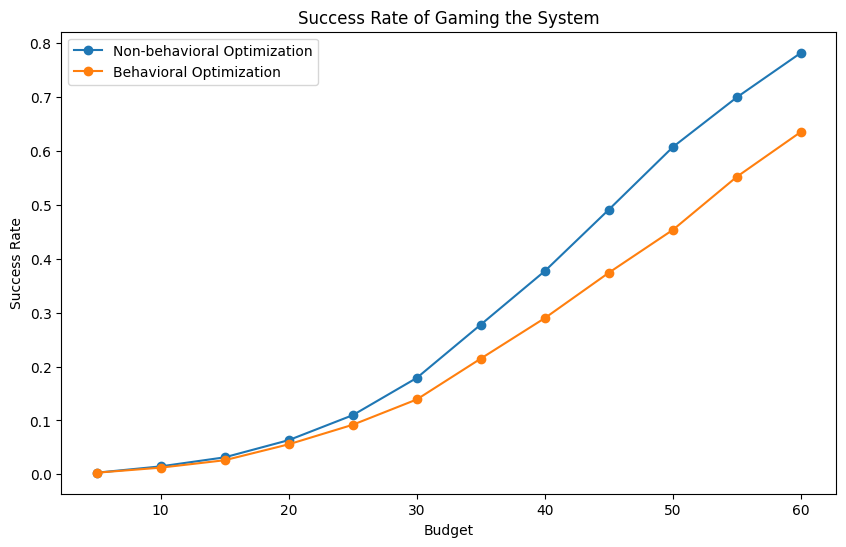

In [29]:
import cvxpy as cp
import numpy as np
import pandas as pd
# import seaborn as sns

# Optimization function to maximize score given the budget
def optimize_features_log(current_features, budget, weights, threshold):
    # Number of features
    n_features = len(current_features)
    
    # Define the optimization variables (amount to increase each feature)
    x = cp.Variable(n_features, nonneg=True)
    
    # Objective function: maximize the weighted sum of features (proxy for FICO score)
    objective = cp.Maximize(cp.sum(cp.multiply(weights, cp.log1p( x / (1 + current_features) ))))
    
    # Constraints
    constraints = [
        cp.sum(x) <= budget,          # Total budget constraint
        # cp.sum(cp.multiply(weights, x + current_features)) <= threshold  # Total score threshold constraint
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Return the new feature values if the problem is feasible
    if problem.status == cp.OPTIMAL:
        return x.value + current_features
    else:
        return current_features

# Predict initial labels
initial_predictions = model.predict(X_test)

# Find users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask]
y_to_optimize = y_test[mask]

gamma = 0.5  # Example gamma value
budget = 10  # Define some budget
threshold = 680  # Define some threshold
model_weights = model.coef_[0]  # Actual model weights
perceived_weights = behavioral(model_weights, gamma)

# Predict initial labels
initial_predictions = model.predict(X_test)

# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=model_weights, threshold=threshold)

# Optimization using perceived weights
optimized_features_perceived = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=perceived_weights, threshold=threshold)

# Predict with the optimized features
optimized_predictions_original = model.predict(optimized_features_original)
optimized_predictions_perceived = model.predict(optimized_features_perceived)

# Calculate success rate
success_rate_original = np.mean(optimized_predictions_original == 1)
print(f"Success rate of gaming the system (Non-behavioral): {success_rate_original:.2%}")

success_rate_perceived = np.mean(optimized_predictions_perceived == 1)
print(f"Success rate of gaming the system (Behavioral): {success_rate_perceived:.2%}")

# do the same for multiple budgets
budgets = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
success_rates_original = []
success_rates_perceived = []

for budget in budgets:
    # Optimization using original weights
    optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=model_weights, threshold=threshold)

    # Optimization using perceived weights
    optimized_features_perceived = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=perceived_weights, threshold=threshold)

    # Predict with the optimized features
    optimized_predictions_original = model.predict(optimized_features_original)
    optimized_predictions_perceived = model.predict(optimized_features_perceived)

    # Calculate success rate
    success_rate_original = np.mean(optimized_predictions_original == 1)
    success_rates_original.append(success_rate_original)

    success_rate_perceived = np.mean(optimized_predictions_perceived == 1)
    success_rates_perceived.append(success_rate_perceived)

# Plotting the success rates
plt.figure(figsize=(10, 6))
plt.plot(budgets, success_rates_original, marker='o', label='Non-behavioral Optimization')
plt.plot(budgets, success_rates_perceived, marker='o', label='Behavioral Optimization')
plt.xlabel('Budget')
plt.ylabel('Success Rate')
plt.title('Success Rate of Gaming the System')
plt.legend()
plt.show()

In [30]:
# plot success rate for different gamma values
budget = 40
gammas = np.linspace(0, 1, 10)
success_rates_p = []
success_rates_o = []
iterations = 1

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=model_weights, threshold=threshold)

# Predict with the optimized features (original weights)
optimized_predictions_original = model.predict(optimized_features_original)

# Calculate success rate (original weights)
success_rate_o = np.mean(optimized_predictions_original == 1)

for gamma in gammas:
    success_rate_p = 0
    for _ in range(iterations):
        # Select users who are true negatives and predicted negatives
        mask = (y_test == 0) & (initial_predictions == 0)
        X_to_optimize = X_test[mask].copy()

        # Optimization using perceived weights
        optimized_features_perceived = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=behavioral(model_weights, gamma), threshold=threshold)
        
        # Predict with the optimized features (perceived weights)
        optimized_predictions_perceived = model.predict(optimized_features_perceived)

        # Calculate success rate (perceived weights)
        success_rate_p += np.mean(optimized_predictions_perceived == 1)
    
    success_rates_p.append(success_rate_p / iterations)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


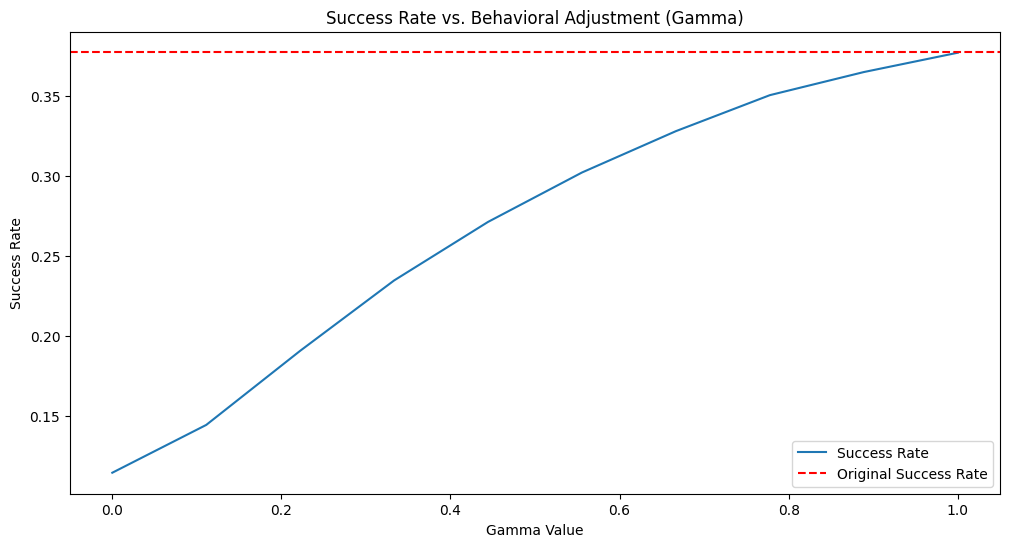

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(gammas, success_rates_p, label='Success Rate')
# plot original success rate
plt.axhline(y=success_rate_o, color='r', linestyle='--', label='Original Success Rate')
plt.xlabel('Gamma Value')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. Behavioral Adjustment (Gamma)')
plt.legend()
# plt.savefig('success_rates.png')
plt.show()

In [32]:
budget = 40  # Define a budget
gamma = 0.5  # Example gamma value

# Select a subset for demonstration (one row for simplicity)
current_features = X_test.iloc[90].values

# Optimize features
optimized_features = optimize_features_log(current_features, budget, model_weights, threshold=threshold)
# For behavioral optimization
optimized_features_perceived = optimize_features_log(current_features, budget, weights=behavioral(model_weights, gamma), threshold=threshold)

# Calculate the changes made to each feature
changes_made = optimized_features - current_features
changes_made_perceived = optimized_features_perceived - current_features

# Display the changes for each feature
print("Changes made to each feature:")
print(changes_made)
print("\nChanges made to each feature (perceived weights):")
print(changes_made_perceived)

Changes made to each feature:
[2.43116292e+01 1.56883706e+01 7.59306573e-08 4.78602686e-08
 5.56037634e-08]

Changes made to each feature (perceived weights):
[2.54601867e+01 1.45398120e+01 6.81091635e-07 1.94344096e-07
 3.23504992e-07]


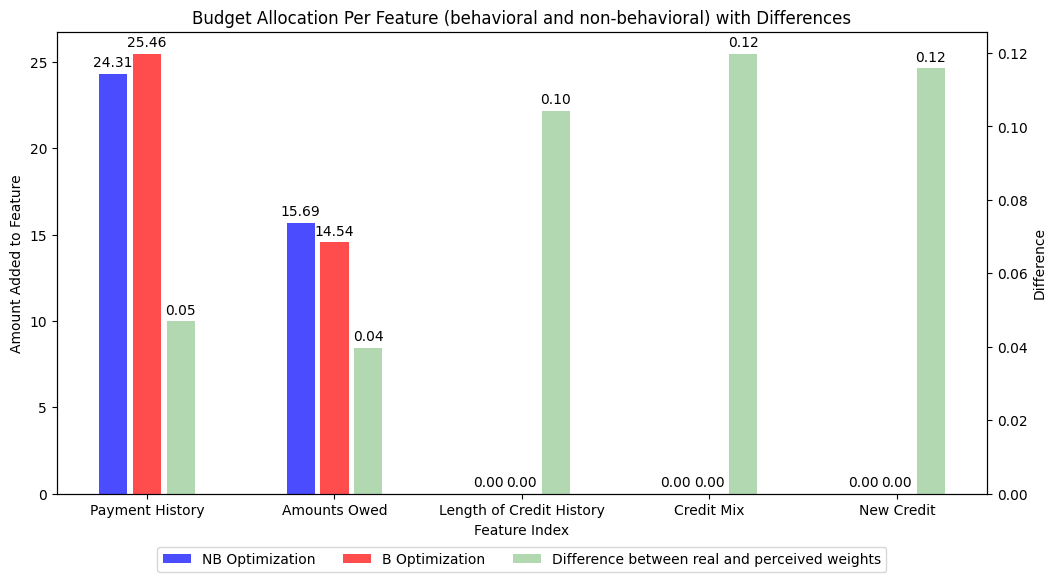

In [33]:
import pandas as pd

# Assuming changes_made, changes_made_perceived, model_weights, and perceived_weights are defined
differences = perceived_weights - model_weights
df = pd.DataFrame({
    'Feature Index': list(range(len(changes_made))) * 3,  # Repeating for each type of data
    'Changes Made': list(changes_made) + list(changes_made_perceived) + list(differences),
    'Type': ['Real Weights']*len(changes_made) + ['Perceived Weights']*len(changes_made_perceived) + ['Difference']*len(differences),
    'Weight Labels': ['NB: {:.1f}'.format(w) for w in model_weights] + ['B: {:.1f}'.format(w) for w in perceived_weights] + ['Diff: {:.1f}'.format(d) for d in differences]
})

import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Locations of the groups
ind = np.arange(len(changes_made))  # the x locations for the groups
width = 0.15  # the width of the bars

# Plot bars for real and perceived weights on primary y-axis
rects1 = ax1.bar(ind - 1.2*width, changes_made, width, label='NB Optimization', color='blue', alpha=0.7)
rects2 = ax1.bar(ind, changes_made_perceived, width, label='B Optimization', color='red', alpha=0.7)

# Create secondary y-axis
ax2 = ax1.twinx()
# Plot bars for differences on secondary y-axis
rects3 = ax2.bar(ind + 1.2*width, differences, width, label='Difference between real and perceived weights', color='green', alpha=0.3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Amount Added to Feature')
ax2.set_ylabel('Difference')
ax1.set_title('Budget Allocation Per Feature (behavioral and non-behavioral) with Differences')
ax1.set_xticks(ind)
# feature names as x-axis labels
ax1.set_xticklabels(['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit'])

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# Attach a text label above each bar in rects1 and rects2, displaying height.
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{:.2f}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects3, ax2)

plt.show()


In [34]:
# plot the same for multiple cases
budget = 20  # Define a budget
gamma = 0.5  # Example gamma value
cases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for case in cases:
    # Select a subset for demonstration (one row for simplicity)
    current_features = X_test.iloc[case].values
    print(f"Case {case}:")
    print(f"Current Features: {current_features}")

    # Optimize features
    optimized_features = optimize_features_log(current_features, budget, model_weights)
    # For behavioral optimization
    optimized_features_perceived = optimize_features_log(current_features, budget, weights=behavioral(model_weights, gamma))

    # Calculate the changes made to each feature
    changes_made = optimized_features - current_features
    changes_made_perceived = optimized_features_perceived - current_features

    # # Display the changes for each feature
    # print("Changes made to each feature:")
    # print(changes_made)
    # print("\nChanges made to each feature (perceived weights):")
    # print(changes_made_perceived)

    import pandas as pd

    # Assuming changes_made, changes_made_perceived, model_weights, and perceived_weights are defined
    differences = perceived_weights - model_weights
    df = pd.DataFrame({
        'Feature Index': list(range(len(changes_made))) * 3,  # Repeating for each type of data
        'Changes Made': list(changes_made) + list(changes_made_perceived) + list(differences),
        'Type': ['Real Weights']*len(changes_made) + ['Perceived Weights']*len(changes_made_perceived) + ['Difference']*len(differences),
        'Weight Labels': ['NB: {:.1f}'.format(w) for w in model_weights] + ['B: {:.1f}'.format(w) for w in perceived_weights] + ['Diff: {:.1f}'.format(d) for d in differences]
    })

    import matplotlib.pyplot as plt
    import numpy as np

    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Locations of the groups
    ind = np.arange(len(changes_made))  # the x locations for the groups
    width = 0.15  # the width of the bars

    # Plot bars for real and perceived weights on primary y-axis
    rects1 = ax1.bar(ind - 1.5*width, changes_made, width, label='NB Optimization', color='blue', alpha=0.7)
    rects2 = ax1.bar(ind, changes_made_perceived, width, label='B Optimization', color='red', alpha=0.7)

    # Create secondary y-axis
    ax2 = ax1.twinx()
    # Plot bars for differences on secondary y-axis
    rects3 = ax2.bar(ind + 1.5*width, differences, width, label='Difference between real and perceived weights', color='green', alpha=0.3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Amount Added to Feature')
    ax2.set_ylabel('Difference')
    ax1.set_title('Budget Allocation Per Feature (behavioral and non-behavioral) with Differences')
    ax1.set_xticks(ind)
    ax1.set_xticklabels(['Feature {}'.format(i) for i in range(len(changes_made))])

    # set the y-axis limits
    ax1.set_ylim(0, 22)
    ax2.set_ylim(0, 0.15)

    # Combine legends from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    # Attach a text label above each bar in rects1 and rects2, displaying height.
    def autolabel(rects, axis):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)
    autolabel(rects3, ax2)

    plt.show()

    print('-'*150)
    print('\n')


Case 0:
Current Features: [96.37881752 68.40021812 42.6        64.2        61.89291704]


TypeError: optimize_features_log() missing 1 required positional argument: 'threshold'

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import numpy as np

# Generate the dataset
df_2 = generate_synthetic_fico_data()
fico_df_2 = df_2.copy()

# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df_2['Approval Probability'] = sigmoid(fico_df_2['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df_2['True Label'] = (fico_df_2['Approval Probability'] > np.random.rand(fico_df_2.shape[0])).astype(int)

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df_2[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df_2['True Label']  # the target variable

In [45]:
# import numpy as np
# import cvxpy as cp
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# def optimize_features_log(current_features, budget, weights):
#     n_features = len(current_features)
#     x = cp.Variable(n_features, nonneg=True)
#     objective = cp.Maximize(cp.sum(cp.multiply(weights, cp.log1p(x / (1 + current_features)))))
#     constraints = [cp.sum(x) <= budget]
#     problem = cp.Problem(objective, constraints)
#     problem.solve()
#     if problem.status == cp.OPTIMAL:
#         return x.value + current_features
#     else:
#         return current_features

# def simulate_feature_manipulation(X, budget, weights):
#     return X.apply(optimize_features_log, axis=1, budget=budget, weights=weights)

# def evaluate_fpr(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     return fp / (fp + tn)

# def update_weights(weights, gradient, learning_rate):
#     return weights - learning_rate * gradient

# # Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# model.fit(X_train, y_train)


# # Initialize weights
# weights = model_full.coef_[0]

# # Define optimization parameters
# max_iterations = 100
# learning_rate = 0.01
# previous_fpr = float('inf')
# fpr_list = []

# for iteration in range(max_iterations):
#     # Simulate feature manipulation for the training set
#     mask = (y_test == 0) & (initial_predictions == 0)
#     X_to_optimize_2 = X_test[mask].copy()

#     X_train_optimized = simulate_feature_manipulation(X_to_optimize_2, budget, weights)

#     # Fit the logistic regression model with the optimized training set
#     model = LogisticRegression()
#     model.fit(X_train_optimized, y_train)

#     # Predict on the test set
#     y_pred = model.predict(X_test)

#     # Evaluate FPR
#     fpr = evaluate_fpr(y_test, y_pred)

#     fpr_list.append(fpr)

#     # Check for convergence (or if FPR increased, indicating need to adjust approach)
#     if fpr >= previous_fpr:
#         break

#     previous_fpr = fpr

#     # Calculate gradient (this is a simplified approach; in practice, you may need a more sophisticated method)
#     gradient = np.dot(X_train_optimized.T, (model.predict_proba(X_train_optimized)[:, 1] - y_train)) / X_train.shape[0]

#     # Update weights
#     weights = update_weights(weights, gradient, learning_rate)

# # Final weights to announce
# announced_weights = weights

# # Plotting the FPR over iterations
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(fpr_list)), fpr_list, marker='o')
# plt.xlabel('Iteration')
# plt.ylabel('False Positive Rate')
# plt.title('False Positive Rate over Iterations')
# plt.show()


In [46]:
# # Printing final feature weights
# print("Final feature weights:")
# for feature, coef in zip(X.columns, announced_weights):
#     print(f"{feature}: {coef:.4f}")

# # Print the final FPR
# print(f"Final False Positive Rate: {fpr:.4f}")

# # Print initial FPR
# initial_fpr = evaluate_fpr(y_test, model.predict(X_test))
# print(f"Initial False Positive Rate: {initial_fpr:.4f}")